In [1]:
import numpy as np
import pandas as pd
import preprocess_images
from caveclient import CAVEclient
import imageryclient as ic
import logging
import urllib3
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed

In [2]:
#suppress warnings with caveclient and urllib3
logging.getLogger("urllib3.connectionpool").setLevel(logging.ERROR)

client = CAVEclient('minnie65_public')
client.version = 1412
myelin_df = client.materialize.query_table('vortex_manual_myelination_v0')

img_client = ic.ImageryClient(client=client)

Table Owner Notice on vortex_manual_myelination_v0: Myelination status assessed for the axon of the VALID_ID, not the pt_root_id.


In [4]:
#create new dataset
columns = [
    "pt_root_id",
    "pt_position",
    "myelin",
    "image_unwr",
    "image",
    "contour_sm",
    "contour_length"
]

# Create empty DataFrame
manual_myelin_dataset = pd.DataFrame(columns=columns)

In [6]:
#load dataset
manual_myelin_dataset = pd.read_pickle("manual_myelin_dataset_2.pkl")

In [7]:
# Helper function to process one myelin point
def fetch_and_process(row, pt_root_id, sk_df, img_client, box_sz_microns):
    ctr = row["pt_position"]
    tag = row["tag"]

    try:
        plane = preprocess_images.pick_normal_plane(ctr, sk_df)
        image, segs = preprocess_images.pull_image_and_segmentation(
            img_client, ctr, pt_root_id, plane, box_sz_microns
        )
        image_unwr, contour_sm = preprocess_images.unwrap_image_along_boundary(image, segs)

        return {
            "pt_root_id": pt_root_id,
            "pt_position": ctr,
            "myelin": tag,
            "image_unwr": image_unwr,
            "image": image,
            "contour_sm": contour_sm,
            "contour_length": len(contour_sm)
        }

    except Exception as e:
        print(f"Error processing point {ctr}: {e}")
        return None

In [33]:
box_sz_microns = 5 # Pick something so that box * 1000 divisible by 40.

processed = 0

# Start with just 1 neuron
for pt_root_id in [864691135441799752, 864691135763975990, 864691135639556411, 864691135970572133]:

    # Get all manual myelin entries for this neuron
    # myelin_neur_df = myelin_df[myelin_df["pt_root_id"] == pt_root_id]

    #filter by tag
    myelin_neur_df = myelin_df[(myelin_df["pt_root_id"] == pt_root_id) & (myelin_df["tag"] == "t")]


    #get first 2000 entries, and filter by tag
    # myelin_neur_df = myelin_df[(myelin_df["pt_root_id"] == pt_root_id) & (myelin_df["tag"] == "f")].sample(n=2000, random_state=42)


    # Get the skeleton
    sk_df = client.skeleton.get_skeleton(pt_root_id, output_format='swc')

    # Filter out entries that already exist
    def is_not_duplicate(row):
        ctr = row["pt_position"]
        return manual_myelin_dataset[
            (manual_myelin_dataset["pt_position"].apply(lambda x: np.array_equal(x, ctr)))
        ].empty

    filtered_rows = myelin_neur_df[myelin_neur_df.apply(is_not_duplicate, axis=1)]

    # Launch parallel fetching
    # processed = 0
    with ThreadPoolExecutor(max_workers=15) as executor:
        futures = [
            executor.submit(fetch_and_process, row, pt_root_id, sk_df, img_client, box_sz_microns)
            for _, row in filtered_rows.iterrows()
        ]

        for future in as_completed(futures):
            result = future.result()
            if result is not None:
                manual_myelin_dataset = pd.concat([manual_myelin_dataset, pd.DataFrame([result])], ignore_index=True)
                processed += 1
                print(f"Processed {processed}: pt_root_id={result['pt_root_id']}")

Processed 1: pt_root_id=864691135441799752
Processed 2: pt_root_id=864691135441799752
Processed 3: pt_root_id=864691135441799752
Processed 4: pt_root_id=864691135441799752
Processed 5: pt_root_id=864691135441799752
Processed 6: pt_root_id=864691135441799752
Processed 7: pt_root_id=864691135441799752
Processed 8: pt_root_id=864691135441799752
Processed 9: pt_root_id=864691135441799752
Processed 10: pt_root_id=864691135441799752
Processed 11: pt_root_id=864691135441799752
Processed 12: pt_root_id=864691135441799752
Processed 13: pt_root_id=864691135441799752
Processed 14: pt_root_id=864691135441799752
Processed 15: pt_root_id=864691135441799752
Processed 16: pt_root_id=864691135441799752
Processed 17: pt_root_id=864691135441799752
Processed 18: pt_root_id=864691135441799752
Processed 19: pt_root_id=864691135441799752
Processed 20: pt_root_id=864691135441799752
Processed 21: pt_root_id=864691135441799752
Processed 22: pt_root_id=864691135441799752
Processed 23: pt_root_id=8646911354417997

In [629]:
#save dataset
manual_myelin_dataset.to_pickle("manual_myelin_dataset_2.pkl")

In [628]:
len(manual_myelin_dataset)

13629

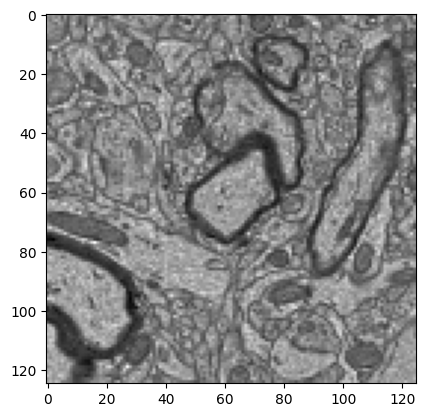

In [51]:
# manual_myelin_dataset.iloc[20]
plt.imshow(manual_myelin_dataset.iloc[190]["image"], cmap='gray')

In [227]:
manual_myelin_dataset.iloc[2067:2070]
#289 and 292 are weird.

,pt_root_id,pt_position,myelin,image_unwr,image,contour_sm,contour_length
2067,864691136578820884,"[360554, 266696, 24074]",t,"[[144.349693410125, 133.3676577591498, 137.403...","[[97.8, 71.8, 90.6, 113.4, 92.8, 94.6, 105.8, ...","[[76.21211139633053, 59.63542520278639], [76.1...",99
2068,864691136578820884,"[361288, 266812, 24082]",f,"[[142.76825722842813, 136.57784277432785, 137....","[[91.0, 111.0, 72.4, 150.6, 139.8, 133.6, 118....","[[72.49747203967607, 65.06497986924562], [72.4...",95
2069,864691136578820884,"[361046, 266764, 24078]",f,"[[141.13975037302632, 140.00015918779744, 142....","[[92.4, 111.6, 100.4, 103.6, 106.6, 100.8, 105...","[[74.00589086503935, 62.55656104388234], [73.9...",93


In [179]:
#for visualization
data_true = manual_myelin_dataset[manual_myelin_dataset["myelin"] == "f"]
cc = 0

217


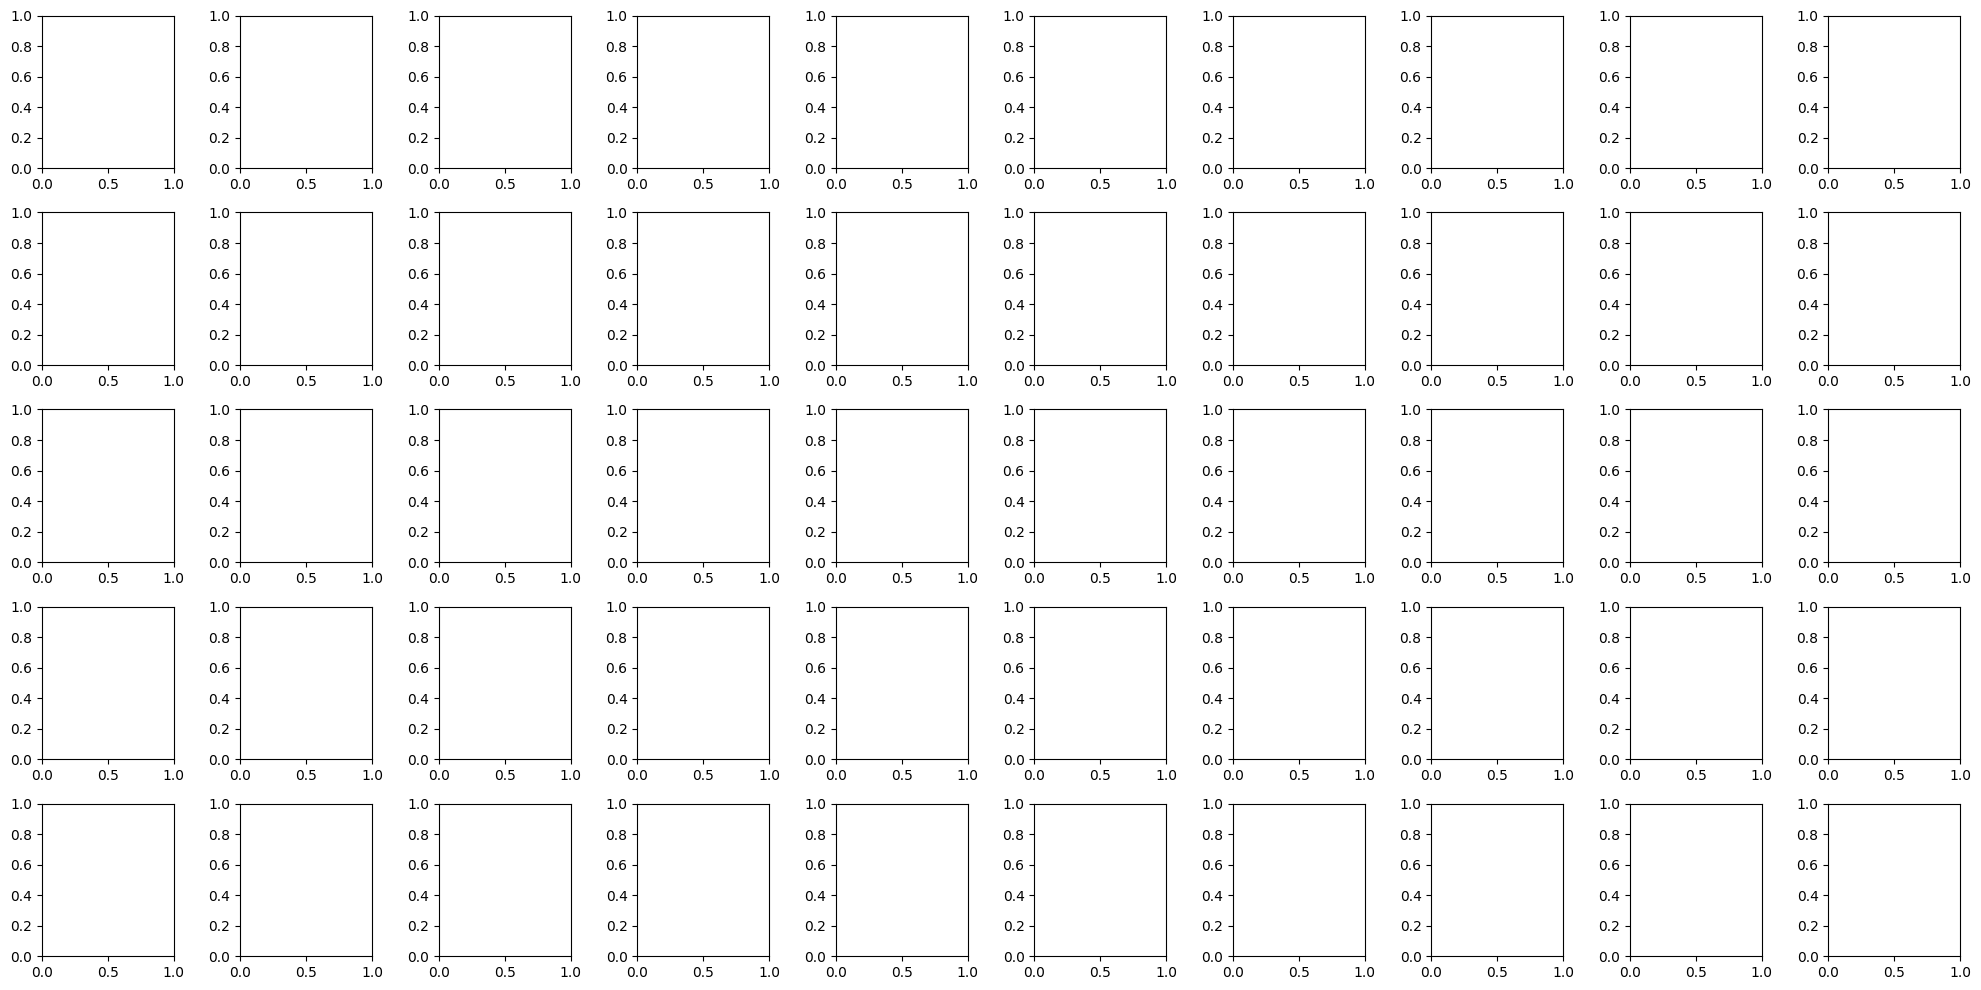

In [625]:
cc += 1
print(cc)

counter = cc*50
# Display the first 50 entries, from the "image" field in a subplot with each subplot having the original DataFrame index as its caption

fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(20, 10))
for ax in axes.flatten():
    if counter < len(data_true):
        row = data_true.iloc[counter]
        img = row["image"]
        contour_sm = row["contour_sm"]
        original_idx = data_true.index[counter]  # Get the original DataFrame index

        ax.imshow(img, cmap="gray", vmin=100, vmax=145)
        ax.plot(contour_sm[:, 1], contour_sm[:, 0], color='yellow', alpha=0.8, linewidth=.5)
        ax.set_title(f"Index: {original_idx}")
        ax.axis("off")
        counter += 1
plt.tight_layout()
plt.show()

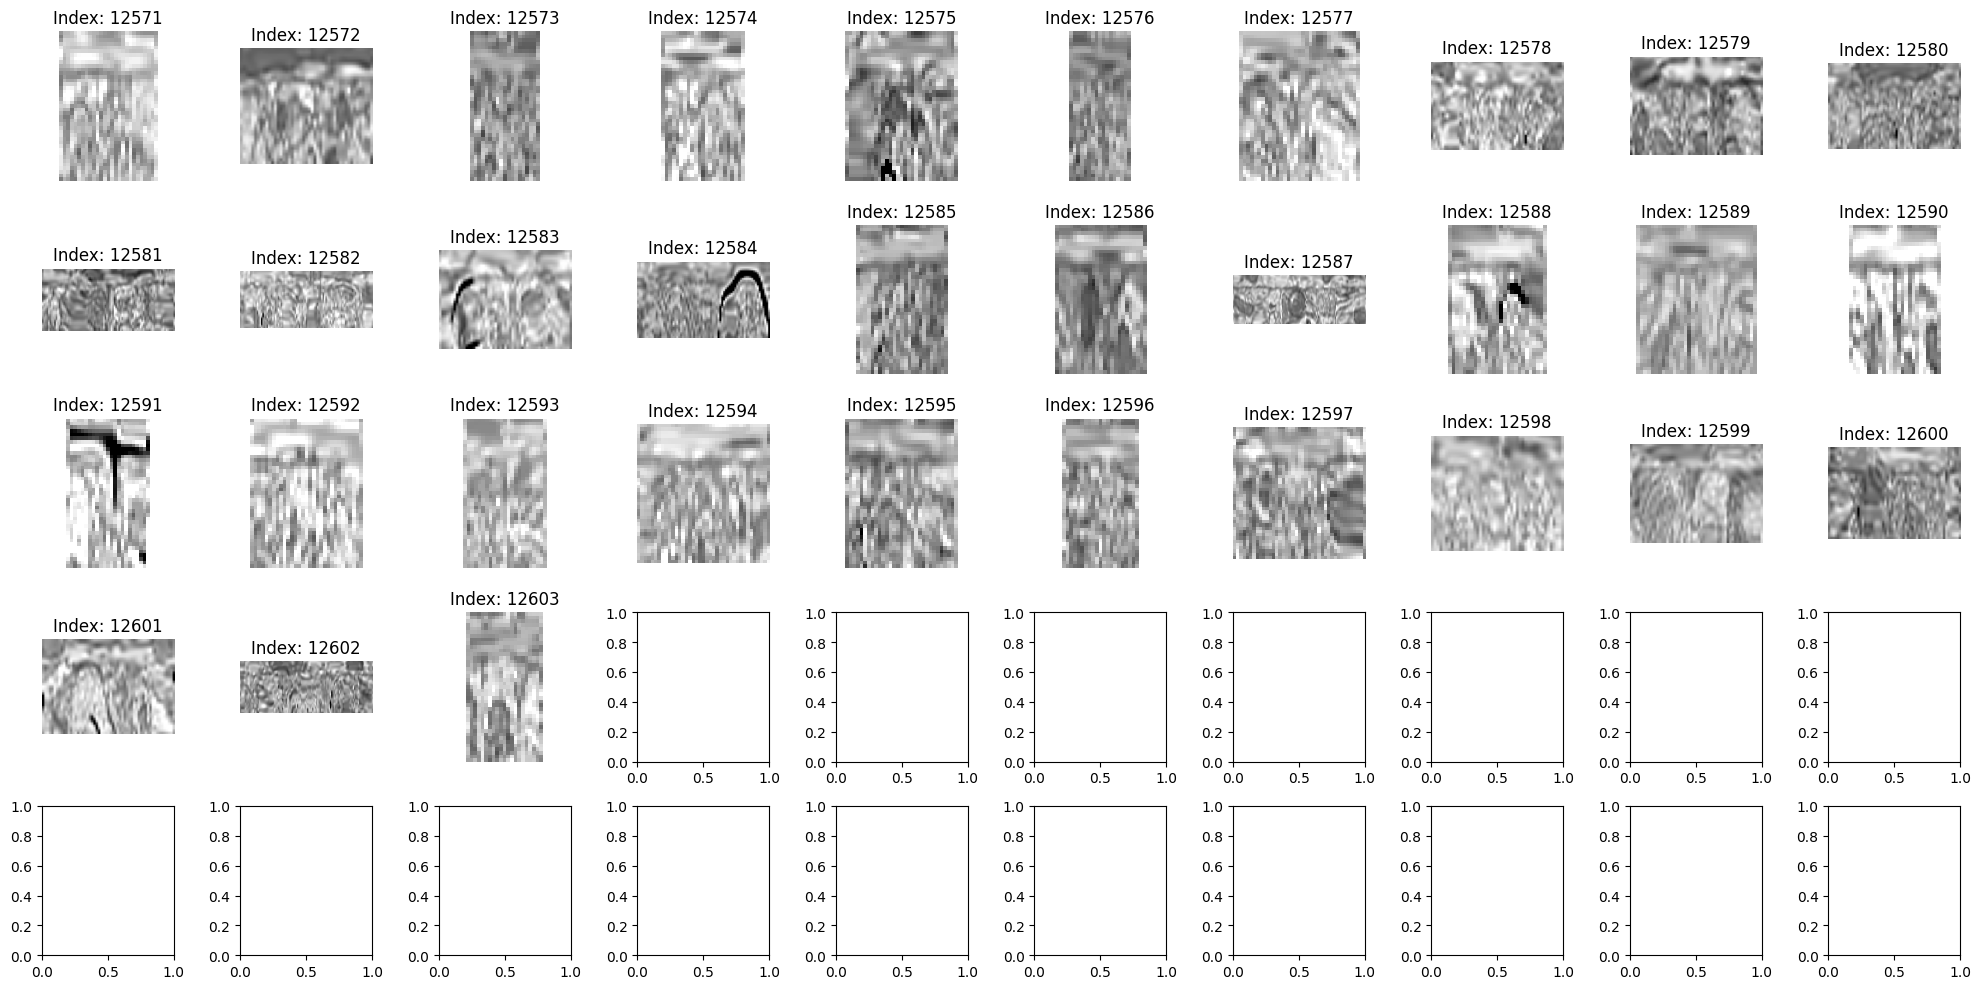

In [624]:
#get unwrapped

counter = cc*50
# Display the first 50 entries, from the "image" field in a subplot with each subplot having the original DataFrame index as its caption

fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(20, 10))
for ax in axes.flatten():
    if counter < len(data_true):
        row = data_true.iloc[counter]
        img = row["image_unwr"]
        contour_sm = row["contour_sm"]
        original_idx = data_true.index[counter]  # Get the original DataFrame index

        ax.imshow(img, cmap="gray", vmin=100, vmax=150)
        # ax.plot(contour_sm[:, 1], contour_sm[:, 0], color='yellow', alpha=0.8, linewidth=1.5)
        ax.set_title(f"Index: {original_idx}")
        ax.axis("off")
        counter += 1
plt.tight_layout()
plt.show()

In [ ]:
#Now, let's put dataset into a format that can be used for training.

Underneath here: code to run once, to remove problematic entries, and to change incorrectly labeled segments

In [627]:
#RUN ONCE. DO NOT TOUCH AFTER.
#remove problematic entries, and change incorrectly labeled segments

#change tag from "f" to "t"
change_list = [
    1908,
    1912,
    2336,
    2204,
    2307,
    2991,
    4591,
    4593,
    4599,
    4601,
    4603
]

#delete indices.
delete_list = [
    2398,
    4590,
    11697,
    289,
    292,
    1522,
    2117,
    3296,
    3287,
    3288,
    3293,
    3294,
    1434,
    1611,
    2065,
    2325,
    2621,
    2627,
    2634,
    12783,
    12876,
    13139,
    13140,
    13175,
    13582,
    13631
]
for idx in change_list:
    manual_myelin_dataset.at[idx, "myelin"] = "t"
for idx in delete_list:
    manual_myelin_dataset = manual_myelin_dataset.drop(idx)

Underneath here is scrap code.

In [ ]:
box_sz_microns = 4 # Pick something divisible by 4.

#start with just 1 neuron.

for pt_root_id in [864691135441799752]:

    #Get all manual myelin entries for this neuron.
    myelin_neur_df = myelin_df[myelin_df["pt_root_id"] == pt_root_id]

    # myelin_neur_df = myelin_df[(myelin_df["pt_root_id"] == pt_root_id) & (myelin_df["tag"] == "f")]


    #Get the skeleton for this neuron.
    sk_df = client.skeleton.get_skeleton(pt_root_id, output_format='swc')

    for idx, row in myelin_neur_df.iterrows():
        print(idx)
        

        ctr = row["pt_position"]
        tag = row["tag"]

        # Check if entry already exists
        already_in = manual_myelin_dataset[
            (manual_myelin_dataset["pt_root_id"] == pt_root_id) &
            (manual_myelin_dataset["pt_position"].apply(lambda x: np.array_equal(x, ctr)))
        ]
        if not already_in.empty:
            continue

        plane = preprocess_images.pick_normal_plane(ctr, sk_df)
        [image,segs] = preprocess_images.pull_image_and_segmentation(img_client, ctr, pt_root_id, plane, box_sz_microns)
        [image_unwr, contour_sm] = preprocess_images.unwrap_image_along_boundary(image, segs)

        #add to dataset
        new_row = pd.DataFrame([{
            "pt_root_id": pt_root_id,
            "pt_position": ctr,
            "myelin": tag,
            "image_unwr": image_unwr,
            "image": image,
            "contour_sm": contour_sm,
            "contour_length": len(contour_sm)
        }])
        manual_myelin_dataset = pd.concat([manual_myelin_dataset, new_row], ignore_index=True)

